In [1]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
sns.set_theme()

In [2]:
lotus = pd.read_csv("../data/230106_frozen_metadata.csv.gz", low_memory=False)
lotus = lotus.rename(columns={'organism_name': 'species', 'structure_smiles_2D': 'molecule'})

In [3]:
directory = '../out/'
dataframes = []  # List to hold dataframes
for filename in os.listdir(directory):
    if filename.endswith('.parquet'):  # Ensures only parquet files are read
        filepath = os.path.join(directory, filename)
        df = pd.read_parquet(filepath)  # Read parquet file to a pandas df
        dataframes.append(df)  # Append the df to the list
df = pd.concat(dataframes, ignore_index=True)

df.prob = df.prob.astype('float32')

In [4]:
pivot_df = df.pivot_table(index='species', columns='molecule', values='prob')
del df

In [5]:
from sklearn.preprocessing import StandardScaler
# Standardize the data (important for PCA)
scaler = StandardScaler()
species_std = scaler.fit_transform(pivot_df)

In [6]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=42,perplexity=50, n_iter=5000)
tsne_data = model.fit_transform(species_std)

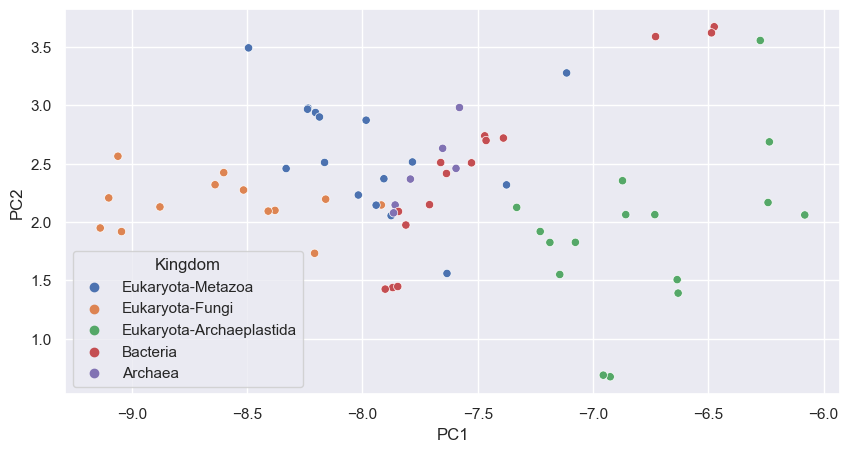

In [7]:
# Create a DataFrame from PCA results
tsne_df = pd.DataFrame(tsne_data, columns=['PC1', 'PC2'])
tsne_df['species'] = pivot_df.index  # Add species column from the index of pivot_df

# Merge the kingdom information into the PCA results dataframe
tsne_df = pd.merge(tsne_df, lotus[['species',
                                 'organism_taxonomy_02kingdom',
                                'organism_taxonomy_01domain']], on='species', how='left').drop_duplicates()
tsne_df['organism_taxonomy_02kingdom'] = tsne_df['organism_taxonomy_02kingdom'].fillna('Unknown')

tsne_df['Kingdom'] = tsne_df['organism_taxonomy_01domain'] + "-" + tsne_df['organism_taxonomy_02kingdom']
tsne_df.replace('Bacteria-Unknown', 'Bacteria', inplace=True)
tsne_df.replace('Archaea-Unknown', 'Archaea', inplace=True)

plt.figure(figsize=(10, 5))
scatter = sns.scatterplot(data=tsne_df, x=tsne_df['PC1'], y=tsne_df['PC2'], hue='Kingdom')

# Set axis labels with explained variance
#plt.xlabel(
#    'PC1 ({:.2%} of variance)'.format(pca.explained_variance_ratio_[0]))
#plt.ylabel(
#    'PC2 ({:.2%} of variance)'.format(pca.explained_variance_ratio_[1]))

# Add species names to the plot
#for line in range(0, tsne_df.shape[0]):
#     plt.text(tsne_df.iloc[line]['PC1']+10, tsne_df.iloc[line]['PC2'],
#              tsne_df.iloc[line]['species'],
#              horizontalalignment='left',
#              size='xx-small',
#              color='black')

In [8]:
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA

# Assuming that 'Kingdom' is your group variable
manova = MANOVA.from_formula('PC1 + PC2 ~ Kingdom', data=tsne_df)
print(manova.mv_test())

                   Multivariate linear model
                                                               
---------------------------------------------------------------
       Intercept         Value  Num DF  Den DF  F Value  Pr > F
---------------------------------------------------------------
          Wilks' lambda  0.0177 2.0000 60.0000 1666.5070 0.0000
         Pillai's trace  0.9823 2.0000 60.0000 1666.5070 0.0000
 Hotelling-Lawley trace 55.5502 2.0000 60.0000 1666.5070 0.0000
    Roy's greatest root 55.5502 2.0000 60.0000 1666.5070 0.0000
---------------------------------------------------------------
                                                               
---------------------------------------------------------------
          Kingdom         Value  Num DF  Den DF  F Value Pr > F
---------------------------------------------------------------
            Wilks' lambda 0.1771 8.0000 120.0000 20.6426 0.0000
           Pillai's trace 0.9376 8.0000 122.0000 13.4578 0.

In [9]:
# Get the means for each group
tsne_df[['PC1', 'PC2', 'Kingdom']].groupby(['Kingdom']).median()

,PC1,PC2
Kingdom,,
Archaea,-7.722272,2.412803
Bacteria,-7.635851,2.506281
Eukaryota-Archaeplastida,-6.865336,1.988543
Eukaryota-Fungi,-8.601688,2.144898
Eukaryota-Metazoa,-8.001095,2.511615


/usr/local/Caskroom/mambaforge/base/envs/stellargraph/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x500 with 0 Axes>

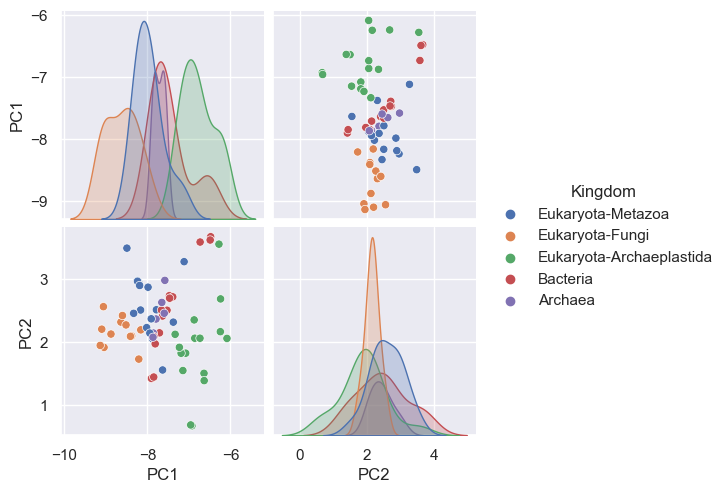

In [10]:
plt.figure(figsize=(10, 5))
sns.pairplot(tsne_df, hue='Kingdom', vars=['PC1', 'PC2'])

<Axes: xlabel='Kingdom', ylabel='PC1'>

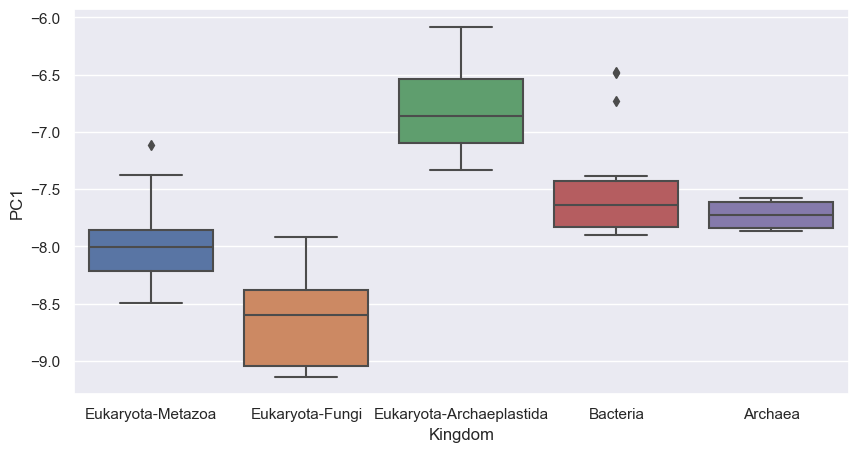

In [11]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=tsne_df, x='Kingdom', y='PC1')

In [12]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Run Tukey's test for PC1
tukey_pc1 = pairwise_tukeyhsd(endog=tsne_df['PC1'], groups=tsne_df['Kingdom'], alpha=0.005)
print(tukey_pc1)

# Run Tukey's test for PC2
tukey_pc2 = pairwise_tukeyhsd(endog=tsne_df['PC2'], groups=tsne_df['Kingdom'], alpha=0.005)
print(tukey_pc2)

                  Multiple Comparison of Means - Tukey HSD, FWER=0.01                   
         group1                   group2          meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------------
                 Archaea                 Bacteria    0.269 0.6305   -0.43   0.968  False
                 Archaea Eukaryota-Archaeplastida   0.9478 0.0001  0.2551  1.6405   True
                 Archaea          Eukaryota-Fungi  -0.8958 0.0002   -1.61 -0.1816   True
                 Archaea        Eukaryota-Metazoa  -0.2443 0.7029  -0.937  0.4484  False
                Bacteria Eukaryota-Archaeplastida   0.6788 0.0001  0.1587  1.1988   True
                Bacteria          Eukaryota-Fungi  -1.1648    0.0 -1.7131 -0.6165   True
                Bacteria        Eukaryota-Metazoa  -0.5134 0.0058 -1.0334  0.0067  False
Eukaryota-Archaeplastida          Eukaryota-Fungi  -1.8436    0.0 -2.3839 -1.3033   True
Eukaryota-Archaeplast